In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
torch.manual_seed(2)
np.random.seed(2)
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler,SequentialSampler
import torchvision.models as models
from torchvision.models import resnet18, resnet34
!pip install torchinfo
!pip install torchattacks
!pip install grad-cam
from torchinfo import summary
from torchvision.models.resnet import _resnet,BasicBlock
import torchattacks
import torchvision.utils

     |████████████████████████████████| 102 kB 5.7 MB/s 


In [3]:
transform = transforms.Compose([
    # transforms.Resize((224)),
    transforms.ToTensor(),
])

batch_size = 64
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)

valset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=batch_size, shuffle=False, num_workers=2, sampler = SequentialSampler(valset.data[5000:10000]),pin_memory=True)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=False, num_workers=2, sampler = SequentialSampler(testset.data[5000:10000]),pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [124]:
from torch.nn import Conv2d,AvgPool2d,Linear,Sequential,Dropout,BatchNorm2d,ModuleList,BatchNorm1d
import torch.nn.functional as F
import numpy as np
import math
from torch.autograd import Variable

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = torch.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out
        return x

class Base(nn.Module):
    def freeze(self):
        for param in self.base_model.parameters():
                param.requires_grad = False
    
    def unfreeze(self):
        for param in self.base_model.parameters():
                param.requires_grad = True
    
    def attach_fea_out(self,classname,input,output):
        self.features.append(output)

    def attach_fea_in(self,classname,input,output):
        self.features.append(input[0])

    def __init__(self,trainable = True,attention=False,base=18):
        super(Base,self).__init__()
        self.features = []
        self.channel_size = []

        if base == 9:
            self.base_model = _resnet('resnet', BasicBlock, [1, 1, 1, 1], False, True)
        elif base==18:
            self.base_model = models.resnet18(pretrained=False)
        else:
            self.base_model = models.resnet34(pretrained=False)

        used_blocks = ['layer1', 'layer2','layer3','layer4']
        unused_blocks = ['avgpool','fc']

        for block in used_blocks:
            getattr(self.base_model,block).register_forward_hook(self.attach_fea_out)

        for block in unused_blocks:
             setattr(self.base_model,block,nn.Identity())
        
        if not trainable:
            self.freeze()

        fake_img = torch.rand(1,3,256,256) ## pass fake img to the model to get the channel size of each inception block
        self.base_model(fake_img)
        self.channel_size = [block.size()[1] for block in self.features]
        self.features = []

    def forward(self,img):
        self.base_model(img)

    def get_MLSP(self,img,feature_type,resize = True):
        self.base_model(img)
        if resize:
            print(resize)
            if feature_type == 'narrow':
                MLSP = [F.adaptive_avg_pool2d(block, (1, 1)) for block in self.features]
                for i in range(len(MLSP)):
                    MLSP[i] = MLSP[i].squeeze(2).squeeze(2)

            if feature_type == 'wide':
                MLSP = [F.interpolate(block,mode = 'bilinear', size = 7) for block in self.features]
            
            MLSP = torch.cat(MLSP,dim = 1)
            self.features = []
        else:
            MLSP = self.features
            self.features = []
        return MLSP


def conv_block(inc,outc,ker,padding = 1,avgpool = False):
        modules = []
        modules.append(nn.Dropout(0.5))
        if avgpool:
            modules.append(AvgPool2d(3,1,1))
        modules.append(Conv2d(inc,outc,ker,padding = padding))
        modules.append(nn.BatchNorm2d(outc))
        modules.append(nn.ReLU())
        return Sequential(*modules)

class Head(nn.Module):
    def conv_block(self,inc,outc,ker,padding = 1,avgpool = False):
        modules = []
        modules.append(nn.Dropout(0.5))
        if avgpool:
            modules.append(AvgPool2d(3,1,1))
        modules.append(Conv2d(inc,outc,ker,padding = padding))
        modules.append(nn.BatchNorm2d(outc))
        modules.append(nn.ReLU())
        return Sequential(*modules)

    def __init__(self,head_type,num_channel):
        super(Head, self).__init__()
        self.head_type = head_type
        self.num_ch = num_channel
        if head_type == 'mlsp_cnn_gap_attn':
            self.attn = []
            self.conv = []
            for i in range(4):
                if i!=3:
                    self.attn.append(CBAM(num_channel[i],reduction_ratio=16))
                else:
                    self.attn.append(CBAM(num_channel[i],reduction_ratio=16,no_spatial=True))
                self.conv.append(Sequential(
                                    self.conv_block(num_channel[i],num_channel[i],1,0),
                                    self.conv_block(num_channel[i],num_channel[i],3,1),
                          ))
            self.attn = ModuleList(self.attn)
            self.conv = ModuleList(self.conv)
        self.dense = Sequential(Linear(960,10))
    def forward(self,features):
        if self.head_type == 'mlsp_gap':
            x = torch.cat([F.adaptive_avg_pool2d(feature, (1, 1)) for feature in features],dim=1)
        else:
            x = torch.cat([F.adaptive_avg_pool2d(block2(block1(feature)+feature),(1,1)) for feature,block1,block2 in zip(features,self.attn,self.conv)],dim=1)
        x = torch.flatten(x, 1)
        x = self.dense(x)
        return x

class Fmodel(nn.Module):
    def __init__(self, head_type='mlsp_gap',base = 18):
        super(Fmodel,self).__init__()
        self.bmodel = Base(base=base)
        self.head = Head(head_type,self.bmodel.channel_size)
        self.feature_type = 'narrow'    
        self.resize = False
        self.gap_fea = []
        self.handles = []
        
    def forward(self,img):
        x = self.bmodel.get_MLSP(img,self.feature_type,self.resize)
        x = self.head(x)
        return x

    def unfreeze(self):
        self.bmodel.unfreeze()
    
    def freeze(self):
        self.bmodel.freeze()

    def hook_gap(self):
        handle = self.head.dense.register_forward_hook(lambda layer, inl, _,: self.gap_fea.append(inl[0]))
        self.handles += [handle]
        return handle

    def hook(self):
        self.hook_gap()

    def unhook(self):
        for fea in self.gap_fea:
            fea.cpu().detach()
        self.gap_fea = []
        for h in self.handles:
            h.remove()
        self.handles = []


In [5]:
test_loader1 = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2, sampler = SequentialSampler(testset.data[9000:10000]))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Meta():
    def hook(self):
        def hook_fn(layer,inl,outl):
            self.fea.append(F.adaptive_avg_pool2d(outl.detach(),(1,1)).cpu())

        for i in range(4):
            try:
                # self.models[i].head.dense.register_forward_hook(lambda layer, inl, _,: self.fea.append(inl[0].detach().cpu()))
                self.models[i].bmodel.base_model.layer1.register_forward_hook(hook_fn)
                self.models[i].bmodel.base_model.layer2.register_forward_hook(hook_fn)
                self.models[i].bmodel.base_model.layer3.register_forward_hook(hook_fn)
                self.models[i].bmodel.base_model.layer4.register_forward_hook(hook_fn)
            except:
                # self.models[i].fc.register_forward_hook(lambda layer, inl, _,: fea_final.append(inl[0].detach().cpu()))
                self.models[i].layer1.register_forward_hook(hook_fn)
                self.models[i].layer2.register_forward_hook(hook_fn)
                self.models[i].layer3.register_forward_hook(hook_fn)
                self.models[i].layer4.register_forward_hook(hook_fn)


    def eval(self):
        for i in range(self.nmodel):
            model = self.models[i]
            acc = []
            correct = 0 
            size = 0
            with  torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    inputs = transforms.functional.normalize(inputs,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                    prediction= model(inputs)
                    _, predicted_class = torch.max(prediction.data, 1)
                    correct += (predicted_class == labels).float().sum().item()
                    size+=len(prediction)
            test_accuracy = correct / size
            acc.append(test_accuracy)

            atks = [torchattacks.FGSM(model, eps=8/255),   torchattacks.PGD(model, eps=8/255, alpha=2/225, steps=7, random_start=True)]            
            for j in [0,1]:
                correct = 0
                start = time.time()
                size = 0
                for images, labels in test_loader:   
                    fea = []
                    adv_images = atks[j](images, labels)
                    labels = labels.to(device)
                    adv_images = transforms.functional.normalize(adv_images,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                    outputs = model(adv_images)
                    _, pre = torch.max(outputs.data, 1)
                    correct += (pre == labels).float().sum().item()
                    size+=len(labels)

                acc.append(correct / size)  

            self.acc.append(acc)

        print(self.path, np.array(self.acc).mean(axis=0))

    def __init__(self,name,path,base=18,head_type='mlsp_gap',nmodel = 4):
        self.name = name
        self.models = []
        res = 32
        self.acc = []
        self.nmodel = nmodel
        self.path = path
        for i in range(nmodel):
            if 'Fmodel' in name:
                model = globals()[name](base=base,head_type=head_type)
            elif 'resnet9' in name:
                model = _resnet('resnet', BasicBlock, [1, 1, 1, 1], False, True)
                model.fc = Linear(512,10)
            else:
                model = globals()[name](pretrained=False)
                model.fc = Linear(512,10)

            model.to(device)
            # model.load_state_dict(torch.load(prefix+path+f'_{i}',map_location=torch.device('cpu')))
            model.load_state_dict(torch.load(prefix+path+f'_{i}'))
            model.eval()
            self.models.append(model)

    def extract_fea(self):
        self.adv_fea = [[],[],[],[]]
        self.fea = [[],[],[],[]]
        
        for model_ind in range(self.nmodel):
            cnt = 0
            model = self.models[model_ind]
            atk = torchattacks.FGSM(model, eps=8/255)
            for images, labels in test_loader1:  
                if 'resnet' not in self.name:
                    adv_images = atk(images, labels)      
                    model.hook_gap()
                    images = images.to(device)
                    images = torch.cat((images,adv_images),dim=0)
                    images = transforms.functional.normalize(images,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                    out = model(images)
                    self.fea[model_ind].append(model.gap_fea[0][:100].cpu().detach())
                    self.adv_fea[model_ind].append(model.gap_fea[0][100:].cpu().detach())
                    model.unhook()

                else:
                    fea_final = []
                    adv_images = atk(images, labels) 
                    handle  = model.fc.register_forward_hook(lambda layer, inl, _,: fea_final.append(inl[0].detach().cpu()))
                    images = images.to(device)
                    images = torch.cat((images,adv_images),dim=0)
                    images = transforms.functional.normalize(images,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                    out = model(images)
                    self.fea[model_ind].append(fea_final[0][:100].cpu().detach())
                    self.adv_fea[model_ind].append(fea_final[0][100:].cpu().detach())
                    fea_final[0].detach()
                    handle.remove()

            self.fea[model_ind] = np.concatenate(self.fea[model_ind],axis=0)
            self.adv_fea[model_ind] = np.concatenate(self.adv_fea[model_ind],axis=0)

prefix = '/content/gdrive/MyDrive/cifar10/new_saved_model/'

In [ ]:
path = 'resnet9_base'
resnet9_base = Meta('resnet9',path)
# resnet9_base.eval()
resnet9_base.extract_fea()
path = 'resnet18_base'
resnet18_base = Meta('resnet18',path)
# resnet18_base.eval()
resnet18_base.extract_fea()
path = 'resnet34_base'
resnet34_base = Meta('resnet34',path)
# resnet34_base.eval()
resnet34_base.extract_fea()

path = 'resnet9_def'
resnet9_def = Meta('resnet9',path)
# resnet9_base.eval()
resnet9_def.extract_fea()
path = 'resnet18_def'
resnet18_def = Meta('resnet18',path)
# resnet18_base.eval()
resnet18_def.extract_fea()
path = 'resnet34_def'
resnet34_def = Meta('resnet34',path)
# resnet34_base.eval()
resnet34_def.extract_fea()

In [125]:
# path = 'mlsp9_base'
# mlsp9_base = Meta('Fmodel',path,9)
# # mlsp9_base.eval()
# mlsp9_base.extract_fea()

# path = 'mlsp18_base'
# mlsp18_base = Meta('Fmodel',path,18)
# # mlsp18_base.eval()
# mlsp18_base.extract_fea()

# path = 'mlsp34_base'
# mlsp34_base = Meta('Fmodel',path,34)
# # mlsp34_base.eval()
# mlsp34_base.extract_fea()

# path = 'mlsp9_def'
# mlsp9_def = Meta('Fmodel',path,9)
# # mlsp9_def.eval()
# mlsp9_def.extract_fea()

# path = 'mlsp18_def'
# mlsp18_def = Meta('Fmodel',path,18)
# # mlsp18_def.eval()
# mlsp18_def.extract_fea()

# path = 'mlsp34_def'
# mlsp34_def = Meta('Fmodel',path,34)
# # mlsp34_def.eval()
# mlsp34_def.extract_fea()

# path = 'mlsp18_def_adareg'
# mlsp18_def_adareg = Meta('Fmodel',path,18)
# # mlsp18_def_adareg.eval()
# mlsp18_def_adareg.extract_fea()


path = 'mlsp18_attn_def'
mlsp18_attn_def = Meta('Fmodel',path,18,head_type='mlsp_cnn_gap_attn')
# mlsp18_attn_def.eval()
mlsp18_attn_def.extract_fea()

path = 'mlsp18_attn_def_adareg'
mlsp18_attn_def_adareg = Meta('Fmodel',path,18,head_type='mlsp_cnn_gap_attn')
# mlsp18_attn_def_adareg.eval()
mlsp18_attn_def_adareg.extract_fea()

path = 'mlsp18_attn_def_adareg_distill'
mlsp18_attn_def_adareg_distill = Meta('Fmodel',path,18,head_type='mlsp_cnn_gap_attn')
# mlsp18_attn_def_adareg_distill.eval()
mlsp18_attn_def_adareg_distill.extract_fea()

In [126]:
import scipy 

def l1_dist(a,b):
    return abs(a-b).mean(axis=0)

def investigate(model):
    global dists_l1
    dist_cos = np.zeros((4,960))
    dist_was = np.zeros((4,960))
    dist_l1 = np.zeros((4,960))

    for model_i in range(4):
        dist_l1[model_i] = l1_dist(model.fea[model_i],model.adv_fea[model_i])

    dists_l1.append(running_mean(np.mean(dist_l1,axis=0),20))
    # dists_l1.append(np.mean(dist_l1,axis=0))
    plot_w(model)

def plot_w(model):
    global dists_w
    plot = [torch.abs(model.models[i].head.dense[0].weight.sum(dim=0)).cpu().detach().numpy() for i in range(4)]
    plot = running_mean(np.mean(plot,axis=0),20)
    # plot = np.mean(plot,axis=0)
    dists_w.append(plot)

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [127]:
dists_l1 = []
dists_w = []

investigate(mlsp9_base)
investigate(mlsp18_base)
investigate(mlsp34_base)
investigate(mlsp9_def)
investigate(mlsp18_def)
investigate(mlsp34_def)
investigate(mlsp18_def_adareg)
investigate(mlsp18_attn_def)
investigate(mlsp18_attn_def_adareg)
investigate(mlsp18_attn_def_adareg_distill)

In [ ]:
plt.figure(figsize=(10,5))
# plt.plot(dists_l1[0], label = 'mlsp9_undef')
# plt.plot(dists_l1[1], label = 'mlsp18_undef')
# plt.plot(dists_l1[2], label = 'mlsp34_undef')
# plt.plot(dists_l1[3], label = 'mlsp9_def')
# plt.plot(dists_l1[4], label = 'mlsp18_def')
# plt.plot(dists_l1[5], label = 'mlsp34_def')
# plt.plot(dists_l1[6], label = 'mlsp18_def_adareg')
# plt.plot(dists_l1[7], label = 'mlsp18_attn_def')
# plt.plot(dists_l1[8], label = 'mlsp18_attn_def_adareg')
plt.title('L1 dist between normal vs adversarial embedding')
plt.xticks([0,64,192,448], ['Layer1','Layer2','Layer3','Layer4'])
plt.legend(loc="right",bbox_to_anchor=(0.9, 0.1))
plt.show()

plt.figure(figsize=(10,5))
# plt.plot(dists_w[0], label = 'mlsp9_undef',c='r')
# plt.plot(dists_w[1], label = 'mlsp18_undef',c='r')
plt.plot(dists_w[2], label = 'mlsp34_undef',c='r')
# plt.plot(dists_w[3], label = 'mlsp9_def',c='r')
# plt.plot(dists_w[4], label = 'mlsp18_def',c='r')
# plt.plot(dists_w[5], label = 'mlsp34_def',c='r')
# plt.plot(dists_w[6], label = 'mlsp18_def_adareg',c='r')
# plt.plot(dists_w[7], label = 'mlsp18_attn_def',c='r')
# plt.plot(dists_w[8], label = 'mlsp18_attn_def_adareg',c='r')
plt.title('Classifier Weight Distribution')
plt.xticks([0,64,192,448], ['Layer1','Layer2','Layer3','Layer4'])
plt.legend(loc="right",bbox_to_anchor=(0.9, 0.1))
plt.show()


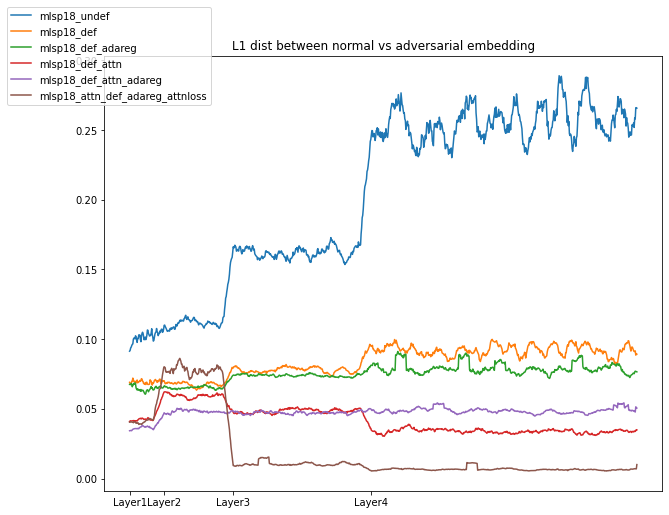

In [128]:
plt.figure(figsize=(10,8))
# plt.plot(dists_l1[0], label = 'mlsp9_undef')
plt.plot(dists_l1[1], label = 'mlsp18_undef')
# plt.plot(dists_l1[2], label = 'mlsp34_undef')
# plt.plot(dists_l1[3], label = 'mlsp9_def')
plt.plot(dists_l1[4], label = 'mlsp18_def')
# plt.plot(dists_l1[5], label = 'mlsp34_def')
plt.plot(dists_l1[6], label = 'mlsp18_def_adareg')
plt.plot(dists_l1[7], label = 'mlsp18_def_attn')
plt.plot(dists_l1[8], label = 'mlsp18_def_attn_adareg')
plt.plot(dists_l1[9], label = 'mlsp18_attn_def_adareg_attnloss')
plt.title('L1 dist between normal vs adversarial embedding')
plt.xticks([0,64,192,448], ['Layer1','Layer2','Layer3','Layer4'])
plt.legend(loc="right",bbox_to_anchor=(0.2, 1))
plt.show()


In [ ]:
# plt.figure(figsize=(20,13))
fig, ax1 = plt.subplots(figsize=(10,8))
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.plot(dists_l1[9], label = 'L1 dist of feature embedding',color = 'tab:red')

ax2 = ax1.twinx()
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.plot(dists_w[9], label = 'Classifier weight distribution',color = 'tab:blue')
ax1.set_xticks([0,64,192,448])
ax1.set_xticklabels(['Layer1','Layer2','Layer3','Layer4'])
ax1.legend(loc="right",bbox_to_anchor=(0.3, 1.05))
ax2.legend(loc="right",bbox_to_anchor=(0.3, 1))
plt.show()


In [ ]:
# plt.figure(figsize=(20,13))
fig, ax1 = plt.subplots(figsize=(10,8))
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.plot(dists_l1[8], label = 'L1 dist of feature embedding',color = 'tab:red')

ax2 = ax1.twinx()
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.plot(dists_w[8], label = 'Classifier weight distribution',color = 'tab:blue')
ax1.set_xticks([0,64,192,448])
ax1.set_xticklabels(['Layer1','Layer2','Layer3','Layer4'])
ax1.legend(loc="right",bbox_to_anchor=(0.3, 1.05))
ax2.legend(loc="right",bbox_to_anchor=(0.3, 1))
plt.show()


In [9]:
##redesign the head since last layer now can also receive spatial attention enhancement due to 224x224 resolution
class Head(nn.Module):
    def conv_block(self,inc,outc,ker,padding = 1,avgpool = False):
        modules = []
        modules.append(nn.Dropout(0.5))
        if avgpool:
            modules.append(AvgPool2d(3,1,1))
        modules.append(Conv2d(inc,outc,ker,padding = padding))
        modules.append(nn.BatchNorm2d(outc))
        modules.append(nn.ReLU())
        return Sequential(*modules)

    def __init__(self,head_type,num_channel):
        super(Head, self).__init__()
        self.head_type = head_type
        self.num_ch = num_channel
        if head_type == 'mlsp_cnn_gap_attn':
            self.attn = []
            self.conv = []
            for i in range(4):
                self.attn.append(CBAM(num_channel[i],reduction_ratio=16))
                self.conv.append(Sequential(
                                    self.conv_block(num_channel[i],num_channel[i],1,0),
                                    self.conv_block(num_channel[i],num_channel[i],3,1),
                          ))
            self.attn = ModuleList(self.attn)
            self.conv = ModuleList(self.conv)
        self.dense = Sequential(Linear(960,10))
    def forward(self,features):
        if self.head_type == 'mlsp_gap':
            x = torch.cat([F.adaptive_avg_pool2d(feature, (1, 1)) for feature in features],dim=1)
        else:
            x = torch.cat([F.adaptive_avg_pool2d(block2(block1(feature)+feature),(1,1)) for feature,block1,block2 in zip(features,self.attn,self.conv)],dim=1)
        x = torch.flatten(x, 1)
        x = self.dense(x)
        return x


In [12]:
path = 'resnet18_def_224'
resnet18_def_224 = Meta('resnet18',path,nmodel=1)
path = 'mlsp18_def_224'
mlsp18_def_224 = Meta('Fmodel',path,18,head_type='mlsp_gap',nmodel=1)
path = 'mlsp18_attn_def_224'
mlsp18_attn_def_224 = Meta('Fmodel',path,18,head_type='mlsp_cnn_gap_attn',nmodel=1)
path = 'mlsp18_attn_def_adareg_distill_224'
mlsp18_attn_def_adareg_distill_224 = Meta('Fmodel',path,18,head_type='mlsp_cnn_gap_attn',nmodel=1)

In [13]:
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

size = 224
transform = transforms.Compose([
    transforms.Resize((size)),
    transforms.ToTensor(),
])

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testset1 = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True,transform =transform)

def plot_cam(model,target_layers,input_tensor, rgb_img):
    global predictions
    with GradCAM(model=model,
                        target_layers=target_layers,
                        use_cuda=False) as cam:

            # AblationCAM and ScoreCAM have batched implementations.
            # You can override the internal batch size for faster computation.
            cam.batch_size = 1
            
            grayscale_cam = cam(input_tensor=input_tensor,
                                target_category=None)

            # Here grayscale_cam has only one image in the batch
            grayscale_cam = grayscale_cam[0, :]
            # print(model(input_tensor))
            # print(classes[model(input_tensor).argmax().item()], classes[testset[img][1]])
            predictions.append(classes[model(input_tensor).argmax().item()])
            cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            # plt.imshow(cam_image)
            # plt.show()
            return cam_image
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


4128


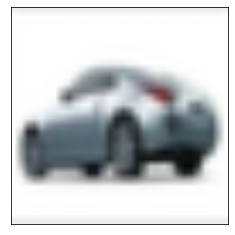

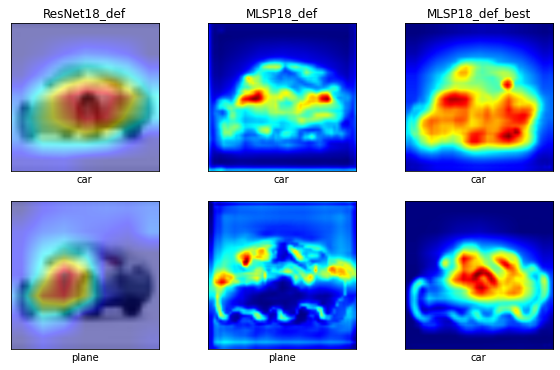

In [87]:
model1 = resnet18_def_224.models[0].eval()
atk1 = torchattacks.PGD(model1, eps=8/255, alpha=2/225, steps=10, random_start=True)
atk1 = torchattacks.FGSM(model1, eps=8/255)
model2 = mlsp18_attn_def_adareg_distill_224.models[0].eval()
atk2 = torchattacks.PGD(model2, eps=8/255, alpha=2/225, steps=10, random_start=True)
atk2 = torchattacks.FGSM(model2, eps=8/255)
predictions = []
while True:
    img = np.random.randint(0,10000)
    input_tensor = testset[img][0].unsqueeze(0).to(device)
    input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    out1a = model1(input_tensor).argmax().item()
    out2a = model2(input_tensor).argmax().item()

    adv_images1 = atk1(input_tensor, torch.tensor(testset[img][1]).unsqueeze(0))
    adv_images2 = atk2(input_tensor, torch.tensor(testset[img][1]).unsqueeze(0))
    adv_images1 = transforms.functional.normalize(adv_images1,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    adv_images2 = transforms.functional.normalize(adv_images2,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    out1b = model1(adv_images1).argmax().item()
    out2b = model2(adv_images2).argmax().item()
    if (out1a==testset[img][1])  and (out1b!=testset[img][1]) and (out2a==testset[img][1]) and (out2b==testset[img][1]):
        break


# img = 433
# img = 124
# img = 105
# img = 7791

a_img = []
b_img = []
print(img)

#########################
model = resnet18_def_224.models[0].to(device).eval()
target_layers = [model.layer4[-1]]
input_tensor = testset[img][0].unsqueeze(0).to(device)
input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
rgb_img = np.array(testset[img][0]).transpose(1,2,0)
plt.imshow(rgb_img)
plt.gca().grid(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show()

a = plot_cam(model,target_layers,input_tensor, rgb_img)
a_img.append(a)
input_tensor = adv_images1
b = plot_cam(model,target_layers,input_tensor, rgb_img)
b_img.append(b)

#####################
model = mlsp18_def_224.models[0].eval()
target_layers = [model.bmodel.base_model.layer4[-1],model.bmodel.base_model.layer3[-1],model.bmodel.base_model.layer2[-1],model.bmodel.base_model.layer1[-2]]
input_tensor = testset[img][0].unsqueeze(0).to(device)
input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
rgb_img = np.array(testset1[img][0]).reshape(size,size,3)/255
a = plot_cam(model,target_layers,input_tensor, rgb_img)
a_img.append(a)
atk = torchattacks.PGD(model, eps=8/255, alpha=2/225, steps=10, random_start=True)
adv_images = atk(input_tensor, torch.tensor(testset[img][1]).unsqueeze(0))
input_tensor = adv_images
input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
b = plot_cam(model,target_layers,input_tensor, rgb_img)
b_img.append(b)

############
model = mlsp18_attn_def_adareg_distill_224.models[0].eval()
target_layers = [layer[-1] for layer in model.head.conv]

input_tensor = testset[img][0].unsqueeze(0).to(device)
input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
rgb_img = np.array(testset1[img][0]).reshape(size,size,3)/255
a = plot_cam(model,target_layers,input_tensor, rgb_img)
a_img.append(a)
input_tensor = adv_images2
b = plot_cam(model,target_layers,input_tensor, rgb_img)
b_img.append(b)

fig, axs = plt.subplots(2, 3,figsize=(10,6))
for i in range(3):
    axs[0][i].imshow(a_img[i])
    axs[0][i].grid(False)
    axs[0][i].set_xticks([])
    axs[0][i].set_yticks([])
    axs[0][i].set_xlabel(predictions[2*i])

    axs[1][i].imshow(b_img[i])
    axs[1][i].grid(False)
    axs[1][i].set_xticks([])
    axs[1][i].set_yticks([])
    axs[1][i].set_xlabel(predictions[2*i+1])

axs[0,0].set_title('ResNet18_def')
axs[0,1].set_title('MLSP18_def')
axs[0,2].set_title('MLSP18_def_best')
plt.show()
    

car plane car car
7583


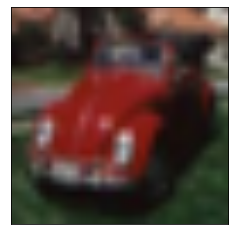

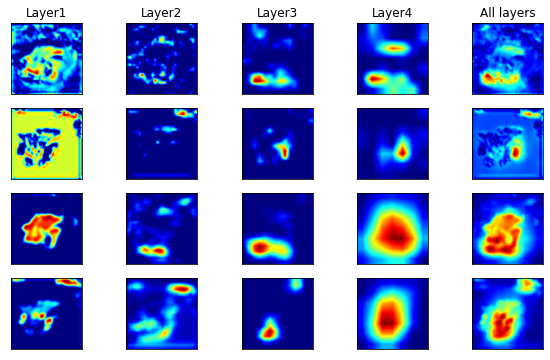

In [122]:
model1 = mlsp18_def_224.models[0].eval()
atk1 = torchattacks.PGD(model1, eps=8/255, alpha=2/225, steps=10, random_start=True)
model2 = mlsp18_attn_def_adareg_distill_224.models[0].eval()
atk2 = torchattacks.PGD(model2, eps=8/255, alpha=2/225, steps=10, random_start=True)
predictions = []
while True:
    img = np.random.randint(0,10000)
    input_tensor = testset[img][0].unsqueeze(0).to(device)
    input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    out1a = model1(input_tensor).argmax().item()
    out2a = model2(input_tensor).argmax().item()

    adv_images1 = atk1(input_tensor, torch.tensor(testset[img][1]).unsqueeze(0))
    adv_images2 = atk2(input_tensor, torch.tensor(testset[img][1]).unsqueeze(0))
    adv_images1 = transforms.functional.normalize(adv_images1,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    adv_images2 = transforms.functional.normalize(adv_images2,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    out1b = model1(adv_images1).argmax().item()
    out2b = model2(adv_images2).argmax().item()
    if (out1a==testset[img][1])  and (out1b!=testset[img][1]) and (out2a==testset[img][1]) and (out2b==testset[img][1]):
        print(classes[out1a],classes[out1b],classes[out2a],classes[out2b])
        break


# img = 433
# img = 124
# img = 105
# img = 7791

a_img = []
b_img = []
c_img = []
d_img = []
a_img = []
b_img = []
print(img)

rgb_img = np.array(testset[img][0]).transpose(1,2,0)
plt.imshow(rgb_img)
plt.gca().grid(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show()

#####################
model = mlsp18_def_224.models[0].eval()
target_layers = [model.bmodel.base_model.layer1[-1],model.bmodel.base_model.layer2[-1],model.bmodel.base_model.layer3[-1],model.bmodel.base_model.layer4[-2]]
for i in range(4):
    input_tensor = testset[img][0].unsqueeze(0).to(device)
    input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    rgb_img = np.array(testset1[img][0]).reshape(size,size,3)/255
    a = plot_cam(model,[target_layers[i]],input_tensor, rgb_img)
    a_img.append(a)
    atk = torchattacks.PGD(model, eps=8/255, alpha=2/225, steps=10, random_start=True)
    adv_images = atk(input_tensor, torch.tensor(testset[img][1]).unsqueeze(0))
    input_tensor = adv_images
    input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    b = plot_cam(model,[target_layers[i]],input_tensor, rgb_img)
    b_img.append(b)

input_tensor = testset[img][0].unsqueeze(0).to(device)
input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
rgb_img = np.array(testset1[img][0]).reshape(size,size,3)/255
a = plot_cam(model,target_layers,input_tensor, rgb_img)
a_img.append(a)
atk = torchattacks.PGD(model, eps=8/255, alpha=2/225, steps=10, random_start=True)
adv_images = atk(input_tensor, torch.tensor(testset[img][1]).unsqueeze(0))
input_tensor = adv_images
input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
b = plot_cam(model,target_layers,input_tensor, rgb_img)
b_img.append(b)

############
model = mlsp18_attn_def_adareg_distill_224.models[0].eval()
target_layers = [layer[-1] for layer in model.head.conv]
for i in range(4):
    input_tensor = testset[img][0].unsqueeze(0).to(device)
    input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    rgb_img = np.array(testset1[img][0]).reshape(size,size,3)/255
    c = plot_cam(model,[target_layers[i]],input_tensor, rgb_img)
    c_img.append(c)
    input_tensor = adv_images2
    d = plot_cam(model,[target_layers[i]],input_tensor, rgb_img)
    d_img.append(d)

input_tensor = testset[img][0].unsqueeze(0).to(device)
input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
rgb_img = np.array(testset1[img][0]).reshape(size,size,3)/255
c = plot_cam(model,target_layers,input_tensor, rgb_img)
c_img.append(c)
input_tensor = adv_images2
d = plot_cam(model,target_layers,input_tensor, rgb_img)
d_img.append(d)

fig, axs = plt.subplots(4, 5,figsize=(10,6))
def plot(x,y,img):
    axs[x][y].imshow(img)
    axs[x][y].grid(False)
    axs[x][y].set_xticks([])
    axs[x][y].set_yticks([])

for i in range(5):
    plot(0,i,a_img[i])
    plot(1,i,b_img[i])
    plot(2,i,c_img[i])
    plot(3,i,d_img[i])

axs[0,0].set_title('Layer1')
axs[0,1].set_title('Layer2')
axs[0,2].set_title('Layer3')
axs[0,3].set_title('Layer4')
axs[0,4].set_title('All layers')
# axs[0,0].set_title('MLSP18_def normal')
# axs[1,0].set_title('MLSP18_def adv')
# axs[2,0].set_title('MLSP18_def_attn normal')
# axs[3,0].set_title('MLSP18_def_attn adv')
plt.show()
    

5431


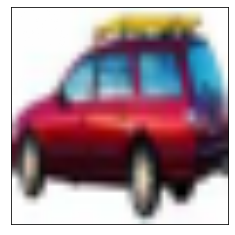

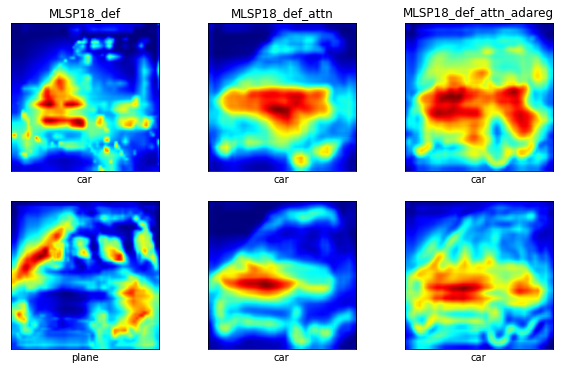

In [ ]:
model1 = mlsp18_def_224.models[0].eval()
atk1 = torchattacks.FGSM(model1, eps=8/255)
model2 = mlsp18_attn_def_adareg_224.models[0].eval()
atk2 = torchattacks.FGSM(model2, eps=8/255)
predictions = []
while True:
    img = np.random.randint(0,10000)
    input_tensor = testset[img][0].unsqueeze(0).to(device)
    input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    out1a = model1(input_tensor).argmax().item()
    out2a = model2(input_tensor).argmax().item()

    adv_images1 = atk1(input_tensor, torch.tensor(testset[img][1]).unsqueeze(0))
    adv_images2 = atk2(input_tensor, torch.tensor(testset[img][1]).unsqueeze(0))
    adv_images1 = transforms.functional.normalize(adv_images1,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    adv_images2 = transforms.functional.normalize(adv_images2,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    out1b = model1(adv_images1).argmax().item()
    out2b = model2(adv_images2).argmax().item()
    if (out1a==testset[img][1])  and (out1b!=testset[img][1]) and (out2a==testset[img][1]) and (out2b==testset[img][1]):
        break


# img = 433
# img = 124
# img = 105
# img = 7791

a_img = []
b_img = []
print(img)

rgb_img = np.array(testset[img][0]).transpose(1,2,0)
plt.imshow(rgb_img)
plt.gca().grid(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show()


#########################
model = mlsp18_def_224.models[0].eval()
target_layers = [model.bmodel.base_model.layer4[-1],model.bmodel.base_model.layer3[-1],model.bmodel.base_model.layer2[-1],model.bmodel.base_model.layer1[-2]]
input_tensor = testset[img][0].unsqueeze(0).to(device)
input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
rgb_img = np.array(testset1[img][0]).reshape(size,size,3)/255
a = plot_cam(model,target_layers,input_tensor, rgb_img)
a_img.append(a)
atk = torchattacks.PGD(model, eps=8/255, alpha=2/225, steps=10, random_start=True)
adv_images = atk(input_tensor, torch.tensor(testset[img][1]).unsqueeze(0))
input_tensor = adv_images
input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
b = plot_cam(model,target_layers,input_tensor, rgb_img)
b_img.append(b)


############
model = mlsp18_attn_def_224.models[0].eval()
target_layers = [layer[-1] for layer in model.head.conv]

input_tensor = testset[img][0].unsqueeze(0).to(device)
input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
rgb_img = np.array(testset1[img][0]).reshape(size,size,3)/255
a = plot_cam(model,target_layers,input_tensor, rgb_img)
a_img.append(a)
input_tensor = adv_images2
b = plot_cam(model,target_layers,input_tensor, rgb_img)
b_img.append(b)

############
model = mlsp18_attn_def_adareg_224.models[0].eval()
target_layers = [layer[-1] for layer in model.head.conv]

input_tensor = testset[img][0].unsqueeze(0).to(device)
input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
rgb_img = np.array(testset1[img][0]).reshape(size,size,3)/255
a = plot_cam(model,target_layers,input_tensor, rgb_img)
a_img.append(a)
input_tensor = adv_images2
b = plot_cam(model,target_layers,input_tensor, rgb_img)
b_img.append(b)


fig, axs = plt.subplots(2, 3,figsize=(10,6))
for i in range(3):
    axs[0][i].imshow(a_img[i])
    axs[0][i].grid(False)
    axs[0][i].set_xticks([])
    axs[0][i].set_yticks([])
    axs[0][i].set_xlabel(predictions[2*i])

    axs[1][i].imshow(b_img[i])
    axs[1][i].grid(False)
    axs[1][i].set_xticks([])
    axs[1][i].set_yticks([])
    axs[1][i].set_xlabel(predictions[2*i+1])

axs[0,0].set_title('MLSP18_def')
axs[0,1].set_title('MLSP18_def_attn')
axs[0,2].set_title('MLSP18_def_attn_adareg')
plt.show()
    

3800


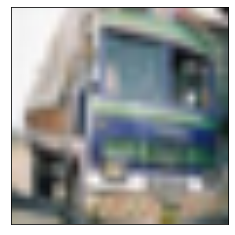

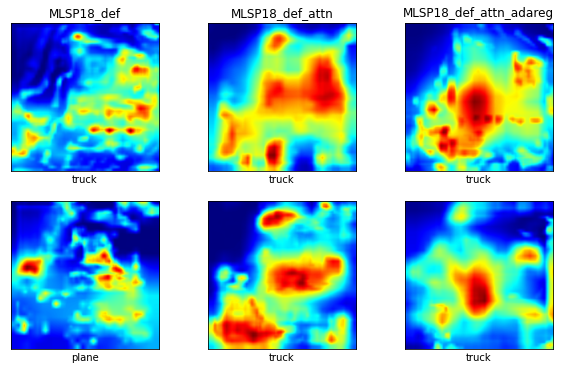

In [ ]:
model1 = mlsp18_def_224.models[0]
atk1 = torchattacks.PGD(model1, eps=8/255, alpha=2/225, steps=10, random_start=True)
model2 = mlsp18_attn_def_adareg_224.models[0]
atk2 = torchattacks.PGD(model2, eps=8/255, alpha=2/225, steps=10, random_start=True)
predictions = []
while True:
    img = np.random.randint(0,10000)
    input_tensor = testset[img][0].unsqueeze(0).to(device)
    input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    out1a = model1(input_tensor).argmax().item()
    out2a = model2(input_tensor).argmax().item()

    adv_images1 = atk1(input_tensor, torch.tensor(testset[img][1]).unsqueeze(0))
    adv_images2 = atk2(input_tensor, torch.tensor(testset[img][1]).unsqueeze(0))
    adv_images1 = transforms.functional.normalize(adv_images1,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    adv_images2 = transforms.functional.normalize(adv_images2,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    out1b = model1(adv_images1).argmax().item()
    out2b = model2(adv_images2).argmax().item()
    if (out1a==testset[img][1])  and (out1b!=testset[img][1]) and (out2a==testset[img][1]) and (out2b==testset[img][1]):
        break


# img = 433
# img = 124
# img = 105
# img = 7791

a_img = []
b_img = []
print(img)

rgb_img = np.array(testset[img][0]).transpose(1,2,0)
plt.imshow(rgb_img)
plt.gca().grid(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show()


#########################
model = mlsp18_def_224.models[0].eval()
target_layers = [model.bmodel.base_model.layer4[-1],model.bmodel.base_model.layer3[-1],model.bmodel.base_model.layer2[-1],model.bmodel.base_model.layer1[-2]]
input_tensor = testset[img][0].unsqueeze(0).to(device)
input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
rgb_img = np.array(testset1[img][0]).reshape(size,size,3)/255
a = plot_cam(model,target_layers,input_tensor, rgb_img)
a_img.append(a)
atk = torchattacks.PGD(model, eps=8/255, alpha=2/225, steps=10, random_start=True)
adv_images = atk(input_tensor, torch.tensor(testset[img][1]).unsqueeze(0))
input_tensor = adv_images
input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
b = plot_cam(model,target_layers,input_tensor, rgb_img)
b_img.append(b)


############
model = mlsp18_attn_def_224.models[0].eval()
target_layers = [layer[-1] for layer in model.head.conv]

input_tensor = testset[img][0].unsqueeze(0).to(device)
input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
rgb_img = np.array(testset1[img][0]).reshape(size,size,3)/255
a = plot_cam(model,target_layers,input_tensor, rgb_img)
a_img.append(a)
input_tensor = adv_images2
b = plot_cam(model,target_layers,input_tensor, rgb_img)
b_img.append(b)

############
model = mlsp18_attn_def_adareg_224.models[0].eval()
target_layers = [layer[-1] for layer in model.head.conv]

input_tensor = testset[img][0].unsqueeze(0).to(device)
input_tensor = transforms.functional.normalize(input_tensor,(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
rgb_img = np.array(testset1[img][0]).reshape(size,size,3)/255
a = plot_cam(model,target_layers,input_tensor, rgb_img)
a_img.append(a)
input_tensor = adv_images2
b = plot_cam(model,target_layers,input_tensor, rgb_img)
b_img.append(b)


fig, axs = plt.subplots(2, 3,figsize=(10,6))
for i in range(3):
    axs[0][i].imshow(a_img[i])
    axs[0][i].grid(False)
    axs[0][i].set_xticks([])
    axs[0][i].set_yticks([])
    axs[0][i].set_xlabel(predictions[2*i])

    axs[1][i].imshow(b_img[i])
    axs[1][i].grid(False)
    axs[1][i].set_xticks([])
    axs[1][i].set_yticks([])
    axs[1][i].set_xlabel(predictions[2*i+1])

axs[0,0].set_title('MLSP18_def')
axs[0,1].set_title('MLSP18_def_attn')
axs[0,2].set_title('MLSP18_def_attn_adareg')
plt.show()
    

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testset1 = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True,transform = transforms.Resize((128)))



Files already downloaded and verified
Files already downloaded and verified


In [ ]:
testset1[1][0].save('img.png')

In [ ]:
%cd pytorch-grad-cam

/content/pytorch-grad-cam


3 types of white box attack 

In [ ]:
import numpy as np

a = np.array([
              [1,0,0,0,0],
              [4/6,1/6,1/6,0,0],
              [0,4/6,1/6,1/6,0],
              [0,0,4/6,1/6,1/6],
              [0,0,0,0,1]
])

a@a

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.77777778, 0.13888889, 0.05555556, 0.02777778, 0.        ],
       [0.44444444, 0.22222222, 0.25      , 0.05555556, 0.02777778],
       [0.        , 0.44444444, 0.22222222, 0.13888889, 0.19444444],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

In [ ]:
#FGSM attack 

#def fgsm_attack(model, loss, images, labels, eps) :
    
 #   images = images.to(device)
#    labels = labels.to(device)
#    images.requires_grad = True
            
#    outputs = model(images)
    
 #   model.zero_grad()
 #   cost = loss(outputs, labels).to(device)
  #  cost.backward()
    
   # attack_images = images + eps*images.grad.sign()
  #  attack_images = torch.clamp(attack_images, 0, 1)
    
    #return attack_images

In [ ]:
torch.save(model.state_dict(),'/content/gdrive/MyDrive/imagenet/saved_model/resnet_attack_adverserial.pt' )


In [ ]:
#torch.save(model.state_dict(),'/content/gdrive/MyDrive/imagenet/saved_model/Fmodel_mlsp_adverserial.pt' )

In [ ]:
#torch.save(model.state_dict(),'/content/gdrive/MyDrive/imagenet/saved_model/Fmodel_mlsp_cnn_gap_attn.pt' )

In [ ]:
#model = Fmodel('mlsp_gap')
model = models.resnet18(pretrained=False)
model.to(device)
#model = torch.load('/content/gdrive/MyDrive/imagenet/saved_model/atk/resnet18_base.pt')
model.load_state_dict(torch.load('/content/gdrive/MyDrive/imagenet/saved_model/attk/resnet18_base.pt'))
#model.load_state_dict(torch.load('/content/gdrive/MyDrive/imagenet/saved_model/resnet_attack_adverserial.pt'))

In [ ]:
!ls /content/gdrive/MyDrive/imagenet/saved_model/attk